# Landmark detection

In [1]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.models import mobilenet_v2
from torchmetrics import MinMetric, MeanMetric
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from xml.etree import ElementTree as ET
from typing import Any, Tuple
from lightning.pytorch.callbacks import EarlyStopping
from lightning import LightningDataModule, LightningModule, Trainer
import torch
import cv2
import wandb
from pytorch_lightning.loggers import WandbLogger
import albumentations as A
import numpy as np


class FaceDataset(Dataset):
    def __init__(self, path, data_dir: str) -> None:
        super().__init__()
        self.images = ET.parse(path).getroot()[2]
        self.data_dir = data_dir
        
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Any:
        data = self.images[index]
        true_width = int(data.attrib['width'])
        true_height = int(data.attrib['height'])
        left = int(data[0].attrib['left'])
        top = int(data[0].attrib['top'])
        width = int(data[0].attrib['width'])
        height = int(data[0].attrib['height'])
        transforms = A.Compose([
            A.Crop(x_min=max(0, left), y_min=max(0, top), x_max=min(left + width, true_width), 
                   y_max=min(top + height, true_height)),
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        landmarks = []
        for landmark in data[0]:
            landmarks.append((float(landmark.attrib['x']), float(landmark.attrib['y'])))
        transformed = transforms(
            image=np.array(Image.open(self.data_dir + data.attrib['file']).convert('RGB')), 
            keypoints=landmarks)
        image = transformed['image']
        landmarks = torch.tensor(transformed['keypoints']).flatten() / 224
        return image, landmarks
    
class FaceDataModule(LightningDataModule):
    def __init__(
        self,
        train_val_split: Tuple[int, int] = (0.8, 0.2),
        data_dir: str = "./data/",
        batch_size: int = 64,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.num_workers = num_workers
        self.train_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
        self.test_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml'
        train_dataset = FaceDataset(self.train_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')
        (self.data_train, self.data_val) = random_split(
            dataset=train_dataset,
            lengths=train_val_split,
            generator=torch.Generator().manual_seed(42),
        )
        self.data_test: Dataset = FaceDataset(self.test_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')

        self.batch_size_per_device = batch_size

    @property
    def num_classes(self) -> int:
        return 136

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

class FaceModule(LightningModule):
    def __init__(self, n_classes: int = 136, lr: float = 1e-4) -> None:
        super().__init__()
        self.i = 0
        self.save_hyperparameters(logger=False)
        self.net = mobilenet_v2(pretrained=True)
        for param in self.net.parameters():
            param.requires_grad = False
        self.net.classifier[1] = torch.nn.Linear(self.net.classifier[1].in_features, self.hparams.n_classes)
        self.criterion = torch.nn.MSELoss()

         # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_loss_best = MinMetric()

    def on_train_start(self) -> None:
        self.train_loss.reset()
        self.val_loss.reset()
        self.val_loss_best.reset()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.train_loss(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.val_loss(loss)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.test_loss(loss)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def predict_step(self, img: Image, left, top, width, height, true_width, true_height) -> Any:
        t = A.Compose([
            A.Crop(x_min=max(0, left), y_min=max(0, top), x_max=min(left + width, true_width), 
                   y_max=min(top + height, true_height)),
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2(),
        ])
        transformed = t(image=np.array(img))
        image = transformed['image']
        image = image.to(self.device)
        logits = self.forward(image.unsqueeze(0))
        return logits.squeeze(0)
    
    def on_validation_epoch_end(self) -> None:
        def draw(image, landmarks, top, left):
            # draw image and point landmarks
            image = image.copy()
            for landmark in landmarks:
                cv2.circle(image, (int(landmark[0]) + left, int(landmark[1]) + top), 1, (0, 255, 0), 5)
            return image
            
        acc = self.val_loss.compute()  # get current val loss
        self.val_loss_best(acc)  # update best so far val loss
        self.log("val_loss_best", self.val_loss_best.compute(), sync_dist=True, prog_bar=True)

        img = Image.open('..\data\ibug_300W_large_face_landmark_dataset\lfpw\trainset\image_0457.png')
        landmarks = self.predict_step(img, left=74, top=78, width=138, height=140, true_width=350, true_height=464)
        landmarks = landmarks.cpu().detach().numpy().reshape((68, 2)) * np.array([138, 140])
        landmarks = landmarks.astype(int)
        img = draw(np.array(img), landmarks, top=78, left=74)
        img = Image.fromarray(img).save(f'../results/{self.i}.jpg')
        self.i += 1
        # self.log('example', wandb.Image(draw(np.array(img), landmarks)))

    def save_to_state_dict(self, path: str):
        torch.save(self.state_dict(), path)

    def load_from_state_dict(self, path: str):
        self.load_state_dict(torch.load(path))
     

In [2]:
model_path = './lightning_logs/version_35/checkpoints/epoch=9-step=840.ckpt'
model = FaceModule.load_from_checkpoint(model_path)
# wandb.login()
# logger = WandbLogger(project="face_landmark", log_model=True)
datamodule = FaceDataModule(data_dir='../data/', batch_size=64, num_workers=0, train_val_split=(0.8, 0.2))
# model = FaceModule(n_classes=datamodule.num_classes, lr=1e-3)

c:\Users\letua\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\letua\miniconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
images, landmarks = next(iter(datamodule.train_dataloader()))

image_1 = images[3]
landmarks_1 = landmarks[3]

image_1 = image_1.permute(1, 2, 0).numpy().astype(np.uint8)
landmarks_1 = landmarks_1.reshape((68, 2)) * np.array([224, 224])
# landmarks_1 = landmarks_1.tolist()

image_1 = image_1.copy()
for landmark in landmarks_1:
    cv2.circle(image_1, (int(landmark[0]), int(landmark[1])), 1, (0, 255, 0), 5)

# cv2.imwrite('../results/0.jpg', image_1)

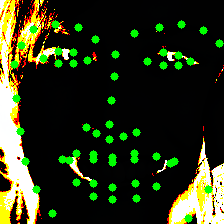

In [32]:
Image.fromarray(image_1)

In [3]:
trainer = Trainer(
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss")],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    # logger=logger,
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\letua\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | net           | MobileNetV2 | 2.4 M 
1 | criterion     | MSELoss     | 0     
2 | train_loss    | MeanMetric  | 0     
3 | val_loss      | MeanMetric  | 0     
4 | test_loss    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\letua\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


OSError: [Errno 22] Invalid argument: '..\\data\\ibug_300W_large_face_landmark_dataset\\lfpw\trainset\\image_0457.png'

In [ ]:
# model.save_to_torchscript('./model.ptl')

# Box detection

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import MinMetric, MeanMetric
from PIL import Image
from xml.etree import ElementTree as ET
from typing import Any, Tuple
from lightning import LightningDataModule, LightningModule, Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from torch.utils.mobile_optimizer import optimize_for_mobile
import numpy as np
import cv2


class FaceBoxDataset(Dataset):
    def __init__(self, path, data_dir: str) -> None:
        super().__init__()
        self.images = ET.parse(path).getroot()[2]
        self.data_dir = data_dir
        
    def __len__(self) -> int:
        return len(self.images)

    def build_label(self, keypoints):
        x1, y1 = keypoints[0]
        x2, y2 = keypoints[1]
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(243, x2)
        y2 = min(243, y2)
        # image array shape (244, 244) with only x1, y1, x2, y2 is 1 and others are 0
        label = np.zeros((244, 244))
        label[int(y1)][int(x1)] = label[int(y2)][int(x2)] = 1
        return torch.tensor(label, dtype=torch.float32).flatten()

    def __getitem__(self, index: int) -> Any:
        data = self.images[index]
        left = int(data[0].attrib['left'])
        top = int(data[0].attrib['top'])
        width = int(data[0].attrib['width'])
        height = int(data[0].attrib['height'])
        box_keypoints = [
            (left, top),
            (left + width, top + height),
        ]
        transforms = A.Compose([
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        transformed = transforms(
            image=np.array(Image.open(self.data_dir + data.attrib['file']).convert('RGB')), 
            keypoints=box_keypoints)
        image = transformed['image']
        box_keypoints = transformed['keypoints']
        label = self.build_label(box_keypoints)
        return image, label
    
class FaceBoxDataModule(LightningDataModule):
    def __init__(
        self,
        train_val_split: Tuple[int, int] = (0.8, 0.2),
        data_dir: str = "./data/",
        batch_size: int = 64,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.num_workers = num_workers
        self.train_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
        self.test_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml'
        train_dataset = FaceBoxDataset(self.train_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')
        (self.data_train, self.data_val) = random_split(
            dataset=train_dataset,
            lengths=train_val_split,
            generator=torch.Generator().manual_seed(42),
        )
        self.data_test: Dataset = FaceBoxDataset(self.test_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')

        self.batch_size_per_device = batch_size

    @property
    def num_classes(self) -> int:
        return 4

    def train_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

class FaceBoxModule(LightningModule):
    def __init__(self, n_classes: int = 4, lr: float = 1e-4) -> None:
        super().__init__()
        self.save_hyperparameters(logger=False)
        # self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
        self.net = mobilenet_v2(pretrained=False)
        self.net.classifier = torch.nn.Linear(1280, self.hparams.n_classes)
        self.criterion = torch.nn.MSELoss()

         # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_loss_best = MinMetric()

    def on_train_start(self) -> None:
        self.train_loss.reset()
        self.val_loss.reset()
        self.val_loss_best.reset()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.train_loss(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.val_loss(loss)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.test_loss(loss)
        self.log("test_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss
    
    def predict_step(self, img: Image) -> Any:
        t = A.Compose([
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ])
        transformed = t(image=np.array(img))
        image = transformed['image'].to(self.device)
        logits = self.forward(image.unsqueeze(0))
        return logits.squeeze(0)
    
    def on_validation_epoch_end(self) -> None:
        acc = self.val_loss.compute()  # get current val loss
        self.val_loss_best(acc)  # update best so far val loss
        self.log("val_loss_best", self.val_loss_best.compute(), sync_dist=True, prog_bar=True)

    def save_to_state_dict(self, path: str):
        torch.save(self.state_dict(), path)

    def save_to_torchscript(self, path: str):
        self.net.eval()
        scripted_model = torch.jit.script(self.net)
        optimized_scripted_model = optimize_for_mobile(scripted_model)
        optimized_scripted_model._save_for_lite_interpreter(path)

    def load_from_state_dict(self, path: str):
        self.load_state_dict(torch.load(path))
     

In [ ]:
datamodule = FaceBoxDataModule(data_dir='../data/', batch_size=16, num_workers=0, train_val_split=(0.8, 0.2))
model = FaceBoxModule(n_classes=244**2)

trainer = Trainer(
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss")],
    accelerator="gpu",
    devices=1,
)

trainer.fit(model, datamodule=datamodule)

In [ ]:
from retinaface import RetinaFace

In [ ]:
resp = RetinaFace.detect_faces('../friends.jpg')
resp

In [ ]:
import pandas as pd

df = pd.read_parquet('../0000.parquet', engine='pyarrow')
df.head()